In [3]:
import pandas as pd
import numpy as np
import cvxpy as cp
import seaborn as sn
import matplotlib.pyplot as plt
from pylab import * 
import csv
import warnings
warnings.filterwarnings('ignore')

In [128]:
def plot_sentiment(dates,sentiment_array,title,dtype):
    plt.plot(dates,sentiment_array[0])
    plt.plot(dates,sentiment_array[1])
    plt.plot(dates,sentiment_array[2])
    plt.legend(["Volume","Favorite","Retweets"])
    if(dtype =='R'):
        plt.ylabel('Quantity')
    if(dtype == 'S'):
        plt.ylabel('Sentiment Score')
    plt.xlabel('Day')
    plt.title(title)

In [17]:
def plot_interactions(dates, interactions, vol,title):
    plt.xlabel('Day')
    plt.ylabel('Quantity')
    plt.title(title)
    plt.plot(dates,interactions)
    plt.plot(dates,vol)
    plt.legend(['Interactions','Volume'])

In [18]:
def sum_stats(stats):
    data = pd.DataFrame(data=stats)
    data = data.T
    return data.describe()

In [200]:
def regime(metadata, n):

    metadata_growth = []

    for i in range (0, len(metadata)-1):
        metadata_growth_val = (metadata[i+1] - metadata[i]) / (metadata[i])
        metadata_growth.append(-metadata_growth_val)    

    x = []
    beta = cp.Variable(n)
    objective = 0
    lambda_val = 0.01
    price = []
    time = []
    
    for i in range(0,n):
        objective += (metadata_growth[i] - beta[i])**2
        if(i >= 1):
            objective += lambda_val*cp.abs(beta[i-1]-beta[i])

    prob = cp.Problem(cp.Minimize(objective))
    prob.solve()

    y = []
    normal = 0
    growth = 0
    growth_times = []
    normal_times = []

    for i in range(0, n):
        b = beta[i]
        val = np.sign(b.value + 1.5)
        if(val <= -1):
            growth += 1
            growth_times.append(i)

        else:
            normal +=1
            normal_times.append(i)
        y.append(val)
    print("The number of normal periods are: " + str(normal))
    print("The number of growth periods are: " + str(growth))
    
    metadata_vals = []
    for i in growth_times:
        metadata_vals.append(-metadata_growth[i])
    
    growth_times = [x+1 for x in growth_times]
    return [growth_times, metadata_vals, normal_times]

In [208]:
def plot_regime(regime_id, dates, metadata,label):
    metadata_growth = []

    for i in range (0, len(metadata)-1):
        metadata_growth_val = (metadata[i+1] - metadata[i]) / (metadata[i])
        metadata_growth.append(metadata_growth_val)
    
    plt.figure(figsize=(10,6))
    plt.title(label + " vs Time")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.plot(dates, metadata_growth)
    plt.scatter(regime_id[0], regime_id[1], c='red', label="Growth Periods")
    plt.legend()
    regime_id[1] = pd.DataFrame(data=regime_id[1])
    regime_id[2] = pd.DataFrame(data=regime_id[2])
    
    print("Growth Regime:", regime_id[1].describe())
    print("Normal Regime:", regime_id[2].describe())

In [273]:
def regime_raw(metadata, n):

    metadata = [x/100 for x in metadata]  

    x = []
    beta = cp.Variable(n)
    objective = 0
    lambda_val = 0.1
    price = []
    time = []
    
    for i in range(0,n):
        objective += (-metadata[i] - beta[i])**2
        if(i >= 1):
            objective += lambda_val*cp.abs(beta[i-1]-beta[i])

    prob = cp.Problem(cp.Minimize(objective))
    prob.solve()

    y = []
    normal = 0
    growth = 0
    growth_times = []
    normal_times = []

    for i in range(0, n):
        b = beta[i]
        val = np.sign(b.value + 1.5)
        if(val <= -1):
            growth += 1
            growth_times.append(i)

        else:
            normal +=1
            normal_times.append(i)
        y.append(val)
    print("The number of normal periods are: " + str(normal))
    print("The number of growth periods are: " + str(growth))
    
    metadata_vals = []
    for i in growth_times:
        metadata_vals.append(-metadata[i])
    
    growth_times = [x+1 for x in growth_times]
    return [growth_times, metadata_vals, normal_times]

In [274]:
def plot_regime_raw(regime_id, dates, metadata,label):
    metadata_growth = []
    regime_id[1] = [-x*100 for x in regime_id[1]]
    
    plt.figure(figsize=(10,6))
    plt.title(label + " vs Time")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.plot(dates, metadata)
    plt.scatter(regime_id[0], regime_id[1], c='red', label="Growth Periods")
    plt.legend()
    regime_id[1] = pd.DataFrame(data=regime_id[1])
    regime_id[2] = pd.DataFrame(data=regime_id[2])
    
    
    print("Growth Regime:", regime_id[1].describe())
    print("Normal Regime:", regime_id[2].describe())

## Trend Filtering Algorithm
### LASSO
$$ \hat{\beta} = argmin_{\beta \in \mathbb{R}^n} \sum_{i=1}^n (x_i - \beta_i)^2 + \lambda \sum_{i=2}^n |\beta_{i-1} - \beta_i| $$

All sections labeled Identifying Regimes, apply the LASSO Trend Filtering Algorithm to track growth regimes 

## Safaricom PLC

In [211]:
data = pd.read_csv("safaricomtweets.csv")
data.head()

,curr date,favorites,retweets,number of tweets,total sentiment,avg sentiment,favorites and retweets,weighted sentiment,avg weighted sentiment,fav sentiment,retweets sentiment
0,1/1/18,3,0,31,0.9901,0.031939,3,0.1863,0.006010,0.1863,0.9901
1,1/2/18,35,63,46,3.0693,0.066724,98,1.8114,0.039378,1.8099,3.0708
2,1/3/18,20,13,25,2.4543,0.098172,33,13.8916,0.555664,9.9569,6.3890
3,1/4/18,12,10,19,2.9264,0.154021,22,6.1117,0.321668,4.1920,4.8461
4,1/5/18,5,2,16,0.2512,0.015700,7,1.2404,0.077525,0.8876,0.6040


### Raw favorites, retweets, volume

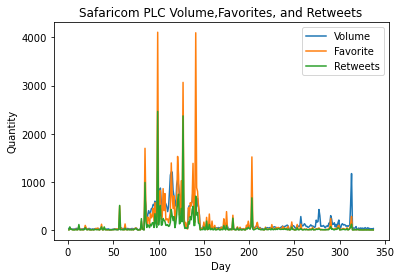

In [419]:
dates = np.linspace(1,337,337)
fav = data.iloc[:,1]
retweets = data.iloc[:,2]
vol = data.iloc[:,3]
plot_sentiment(dates,[vol,fav,retweets], 'Safaricom PLC Volume,Favorites, and Retweets','R')

### Interactions vs Volume

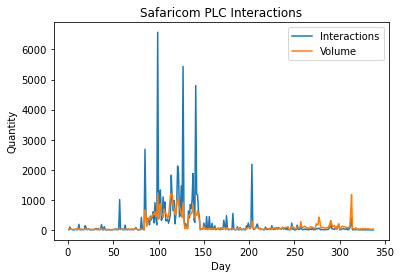

In [420]:
interactions = data.iloc[:,6]
plot_interactions(dates, interactions, vol,'Safaricom PLC Interactions')

### Sentiment Weighted 

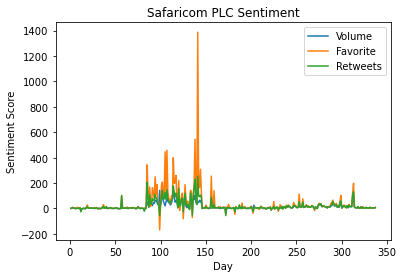

In [421]:
dates = np.linspace(1,337,337)
uw_sentiment = data.iloc[:,4]
fav_sentiment = data.iloc[:,9]
retweets_sentiment = data.iloc[:,10]
sentiment_array = [uw_sentiment,fav_sentiment,retweets_sentiment]
plot_sentiment(dates,sentiment_array, 'Safaricom PLC Sentiment','S')

In [422]:
#Removing outlier: 
uw_sentiment[272] = 0
fav_sentiment[272] = 0
retweets_sentiment[272] = 0

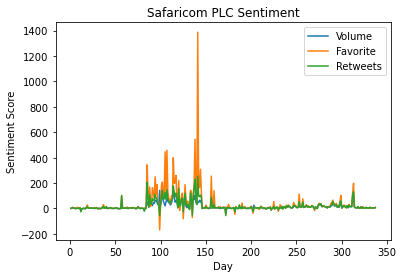

In [423]:
plot_sentiment(dates,[uw_sentiment,fav_sentiment,retweets_sentiment],'Safaricom PLC Sentiment','S')

### Identifying Regimes

In [201]:
dates = np.linspace(1,336,336)
fav = data.iloc[:,1]
retweets = data.iloc[:,2]
vol = data.iloc[:,3]
n = 336
fav= [x+1 for x in fav]
retweets= [x+1 for x in retweets]
vol = [x+1 for x in vol]

The number of normal periods are: 248
The number of growth periods are: 88
Growth Regime:                 0
count   88.000000
mean    13.390211
std     46.279751
min      1.555556
25%      2.180696
50%      4.283333
75%      8.000000
max    423.250000
Normal Regime:                 0
count  248.000000
mean   172.298387
std     98.109002
min      1.000000
25%     90.750000
50%    173.000000
75%    259.250000
max    335.000000
The number of normal periods are: 257
The number of growth periods are: 79
Growth Regime:                 0
count   79.000000
mean    16.932504
std     56.769164
min      1.500000
25%      2.242157
50%      5.000000
75%     11.500000
max    492.500000
Normal Regime:                 0
count  257.000000
mean   169.221790
std     97.454524
min      1.000000
25%     87.000000
50%    168.000000
75%    253.000000
max    335.000000
The number of normal periods are: 317
The number of growth periods are: 19
Growth Regime:                0
count  19.000000
mean    8.067627
s

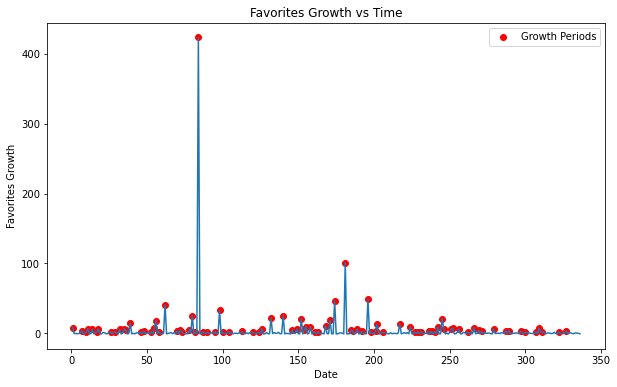

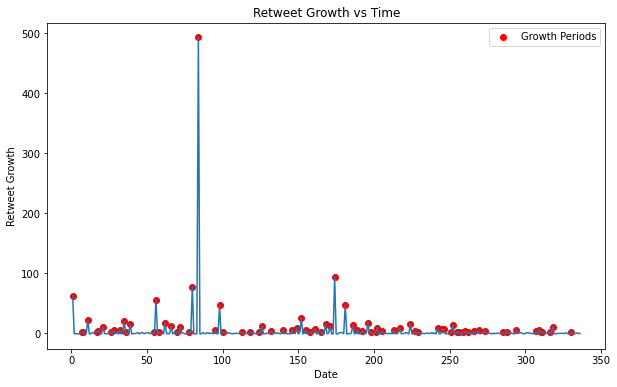

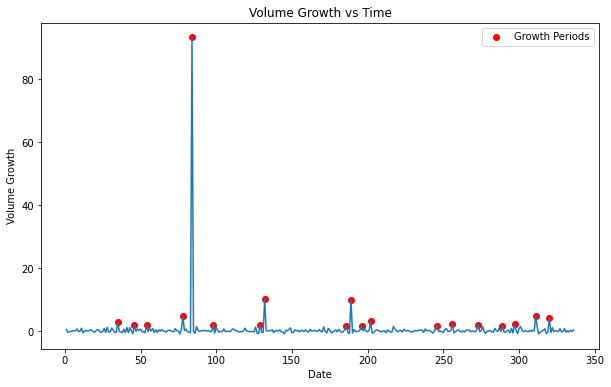

In [202]:
# Favorites 
regime_id = regime(fav, n)
plot_regime(regime_id, dates, fav, 'Favorites Growth')

# Rewteets
regime_id = regime(retweets, n)
plot_regime(regime_id, dates, retweets, 'Retweet Growth')

# Volume
regime_id = regime(vol, n)
plot_regime(regime_id, dates, vol, 'Volume Growth')

The number of normal periods are: 269
The number of growth periods are: 68
Growth Regime:                  0
count    68.000000
mean    633.191176
std     775.418621
min     151.000000
25%     251.500000
50%     351.500000
75%     710.250000
max    4109.000000
Normal Regime:                 0
count  269.000000
mean   178.174721
std    104.448959
min      0.000000
25%     68.000000
50%    197.000000
75%    267.000000
max    336.000000
The number of normal periods are: 304
The number of growth periods are: 33
Growth Regime:                  0
count    33.000000
mean    491.848485
std     534.239888
min     159.000000
25%     212.000000
50%     330.000000
75%     510.000000
max    2465.000000
Normal Regime:                 0
count  304.000000
mean   173.240132
std    100.808407
min      0.000000
25%     76.750000
50%    183.500000
75%    260.250000
max    336.000000
The number of normal periods are: 269
The number of growth periods are: 68
Growth Regime:                  0
count    68.000

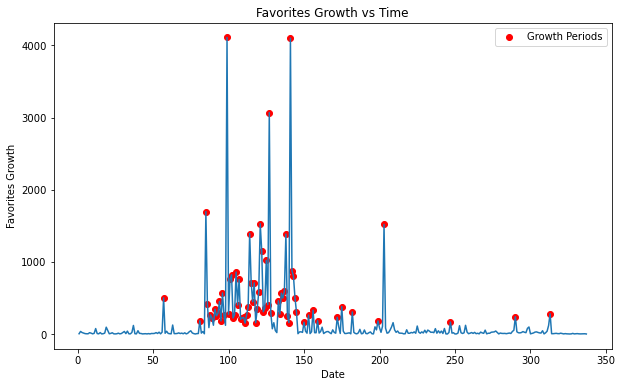

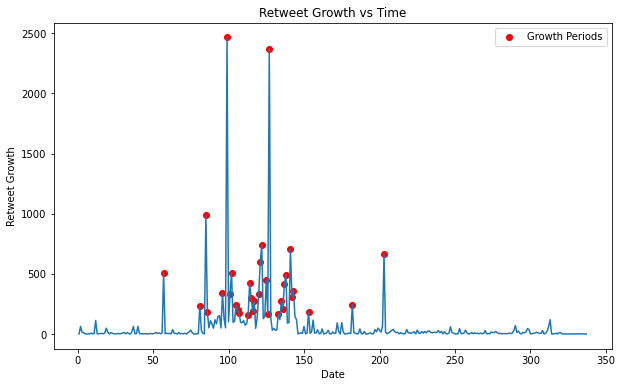

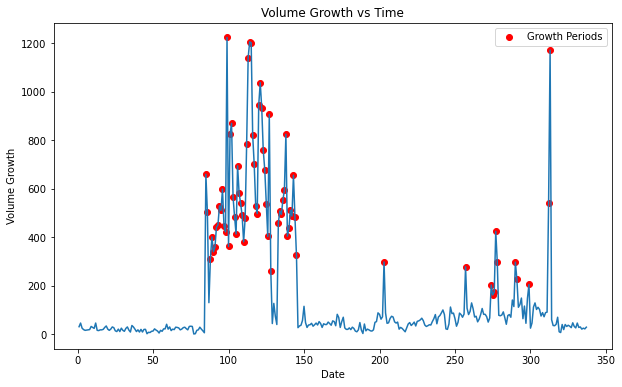

In [275]:
dates = np.linspace(1,337,337)
fav = data.iloc[:,1]
retweets = data.iloc[:,2]
vol = data.iloc[:,3]
n = 337
fav= [x+1 for x in fav]
retweets= [x+1 for x in retweets]
vol = [x+1 for x in vol]
# Favorites 
regime_id = regime_raw(fav, n)
plot_regime_raw(regime_id, dates, fav, 'Favorites Growth')

# Rewteets
regime_id = regime_raw(retweets, n)
plot_regime_raw(regime_id, dates, retweets, 'Retweet Growth')

# Volume
regime_id = regime_raw(vol, n)
plot_regime_raw(regime_id, dates, vol, 'Volume Growth')

## Volkswagen

In [5]:
vw_data = pd.read_csv("vwfreq.csv")
vw_data.head()

,date,favorites sum,retweets sum,volume,total sentiment,avg sentiment,weighted sentiment,avg weighted sentiment,fav sentiment,retweet sentiment
0,9/4/15,51,12,106,26.8187,0.253007,45.0990,0.425462,45.0990,28.6858
1,9/5/15,59,16,67,12.1647,0.181563,32.9801,0.492240,32.9801,19.5741
2,9/6/15,79,12,97,17.8824,0.184355,66.2436,0.682924,66.2436,19.8115
3,9/7/15,49,45,78,10.4914,0.134505,16.4632,0.211067,16.4632,9.5360
4,9/8/15,35,6,71,8.1741,0.115128,20.4559,0.288111,20.4559,13.4715


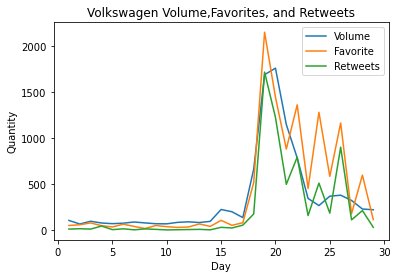

In [425]:
dates = np.linspace(1,29,29)
fav = vw_data.iloc[:,1]
retweets = vw_data.iloc[:,2]
vol = vw_data.iloc[:,3]
plot_sentiment(dates,[vol,fav,retweets], 'Volkswagen Volume,Favorites, and Retweets','R')

### Interactions

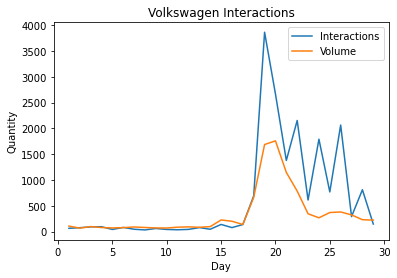

In [426]:
interactions = vw_data.iloc[:,1] + vw_data.iloc[:,2]
plot_interactions(dates, interactions, vol,'Volkswagen Interactions')

### Sentiment Weighted

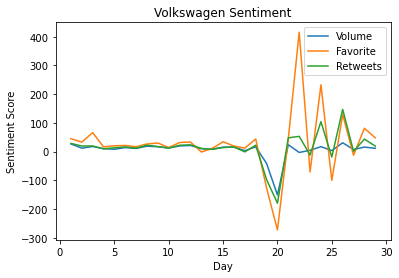

In [427]:
dates = np.linspace(1,29,29)
uw_sentiment = vw_data.iloc[:,4]
fav_sentiment = vw_data.iloc[:,8]
retweets_sentiment = vw_data.iloc[:,9]
sentiment_array = [uw_sentiment,fav_sentiment,retweets_sentiment]
plot_sentiment(dates,sentiment_array, 'Volkswagen Sentiment','S')

### Pre-Scandal 

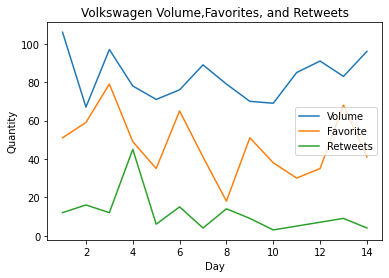

In [428]:
dates = np.linspace(1,14,14)
fav = vw_data.iloc[0:14,1]
retweets = vw_data.iloc[0:14,2]
vol = vw_data.iloc[0:14,3]
plot_sentiment(dates,[vol,fav,retweets], 'Volkswagen Volume,Favorites, and Retweets','R')

In [429]:
sum_stats([vol,fav,retweets])

,volume,favorites sum,retweets sum
count,14.000000,14.000000,14.000000
mean,82.642857,47.142857,11.500000
std,11.933193,16.501082,10.566638
min,67.000000,18.000000,3.000000
25%,72.250000,35.750000,5.250000
50%,81.000000,45.000000,9.000000
75%,90.500000,57.000000,13.500000
max,106.000000,79.000000,45.000000


### Post Scandal

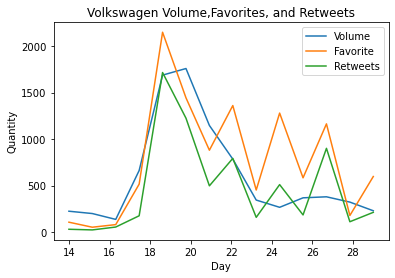

In [430]:
dates = np.linspace(14,29,14)
fav = vw_data.iloc[14:28,1]
retweets = vw_data.iloc[14:28,2]
vol = vw_data.iloc[14:28,3]
plot_sentiment(dates,[vol,fav,retweets], 'Volkswagen Volume,Favorites, and Retweets','R')

In [431]:
sum_stats([vol,fav,retweets])

,volume,favorites sum,retweets sum
count,14.000000,14.000000,14.000000
mean,608.428571,775.000000,471.357143
std,545.592933,628.756404,514.222880
min,137.000000,53.000000,24.000000
25%,239.250000,247.500000,123.750000
50%,357.000000,591.000000,199.000000
75%,754.500000,1251.000000,722.500000
max,1759.000000,2149.000000,1716.000000


### Public Reaction

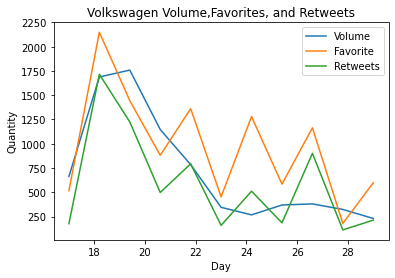

In [432]:
dates = np.linspace(17,29,11)
fav = vw_data.iloc[17:28,1]
retweets = vw_data.iloc[17:28,2]
vol = vw_data.iloc[17:28,3]
plot_sentiment(dates,[vol,fav,retweets], 'Volkswagen Volume,Favorites, and Retweets','R')

In [433]:
sum_stats([vol,fav,retweets])

,volume,favorites sum,retweets sum
count,11.000000,11.000000,11.000000
mean,723.272727,964.454545,589.909091
std,564.674613,574.054242,521.107562
min,230.000000,179.000000,112.000000
25%,334.000000,550.000000,180.500000
50%,380.000000,881.000000,498.000000
75%,966.000000,1320.500000,847.000000
max,1759.000000,2149.000000,1716.000000


### Regime

In [203]:
dates = np.linspace(1,28,28)
fav = vw_data.iloc[:,1]
retweets = vw_data.iloc[:,2]
vol = vw_data.iloc[:,3]
n = 28

The number of normal periods are: 22
The number of growth periods are: 6
Growth Regime:               0
count  6.000000
mean   2.690763
std    1.426862
min    1.609756
25%    1.827539
50%    2.087058
75%    2.958742
max    5.370370
Normal Regime:                0
count  22.000000
mean   12.590909
std     8.505791
min     0.000000
25%     5.250000
50%    11.500000
75%    19.750000
max    27.000000


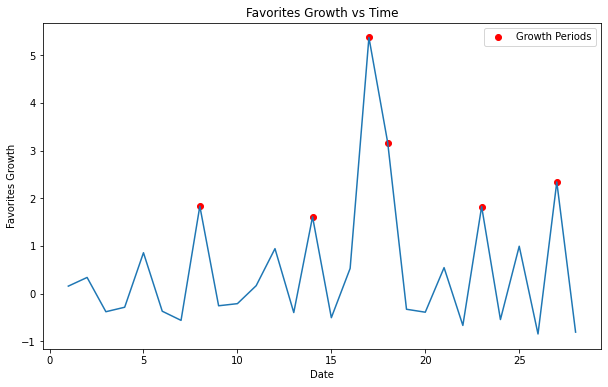

In [204]:
regime_id = regime(fav,n)
plot_regime(regime_id, dates, fav, 'Favorites Growth')

The number of normal periods are: 21
The number of growth periods are: 7
Growth Regime:               0
count  7.000000
mean   4.147730
std    2.589464
min    2.200000
25%    2.356918
50%    2.750000
75%    5.310135
max    8.750000
Normal Regime:                0
count  21.000000
mean   13.238095
std     8.472926
min     0.000000
25%     7.000000
50%    12.000000
75%    20.000000
max    27.000000


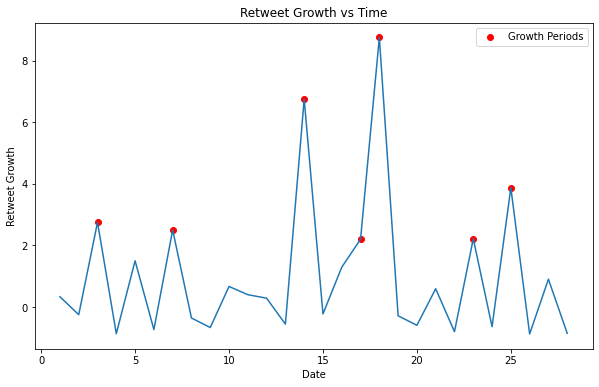

In [205]:
regime_id = regime(retweets,n)
plot_regime(regime_id, dates, retweets, 'Retweet Growth')

The number of normal periods are: 26
The number of growth periods are: 2
Growth Regime:               0
count  2.000000
mean   2.692710
std    1.621688
min    1.546003
25%    2.119356
50%    2.692710
75%    3.266063
max    3.839416
Normal Regime:                0
count  26.000000
mean   13.269231
std     8.502036
min     0.000000
25%     6.250000
50%    12.500000
75%    20.750000
max    27.000000


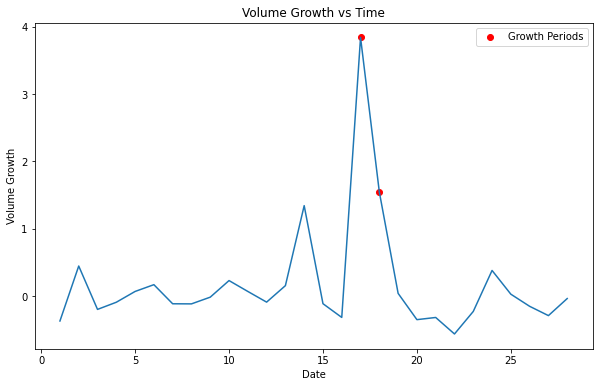

In [206]:
regime_id = regime(vol,n)
plot_regime(regime_id, dates, vol, 'Volume Growth')

### Regime Raw

The number of normal periods are: 18
The number of growth periods are: 11
Growth Regime:                  0
count    11.000000
mean    964.454545
std     574.054242
min     179.000000
25%     550.000000
50%     881.000000
75%    1320.500000
max    2149.000000
Normal Regime:                0
count  18.000000
mean    9.111111
std     6.798693
min     0.000000
25%     4.250000
50%     8.500000
75%    12.750000
max    28.000000
The number of normal periods are: 19
The number of growth periods are: 10
Growth Regime:                  0
count    10.000000
mean    637.700000
std     523.269009
min     159.000000
25%     192.000000
50%     504.500000
75%     874.000000
max    1716.000000
Normal Regime:                0
count  19.000000
mean   10.000000
std     7.659417
min     0.000000
25%     4.500000
50%     9.000000
75%    13.500000
max    28.000000
The number of normal periods are: 15
The number of growth periods are: 14
Growth Regime:                  0
count    14.000000
mean    614.50000

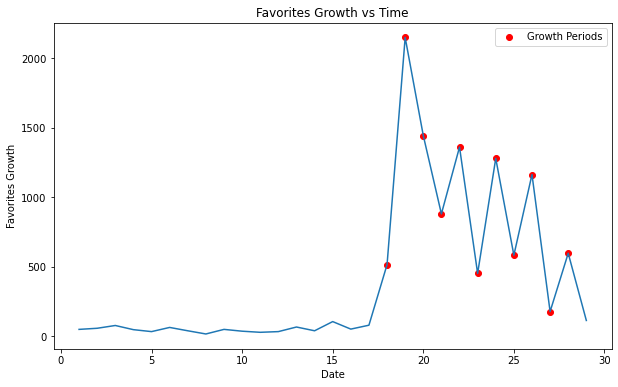

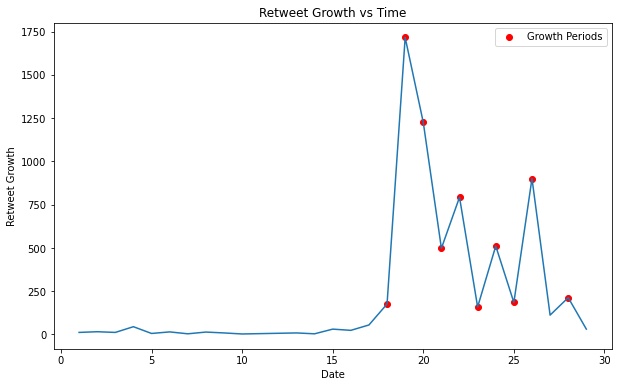

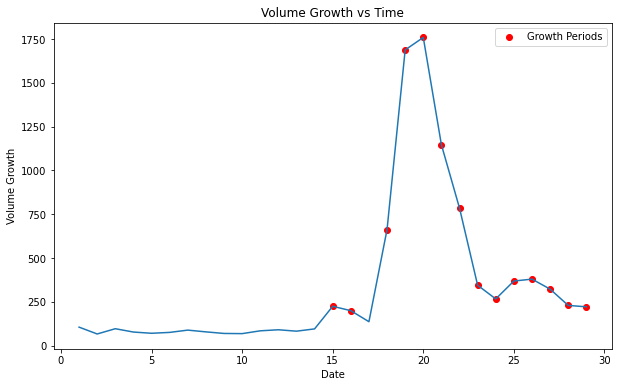

In [276]:
dates = np.linspace(1,29,29)
fav = vw_data.iloc[:,1]
retweets = vw_data.iloc[:,2]
vol = vw_data.iloc[:,3]
n = 29
regime_id = regime_raw(fav,n)
plot_regime_raw(regime_id, dates, fav, 'Favorites Growth')
regime_id = regime_raw(retweets,n)
plot_regime_raw(regime_id, dates, retweets, 'Retweet Growth')
regime_id = regime_raw(vol,n)
plot_regime_raw(regime_id, dates, vol, 'Volume Growth')

## Wells Fargo

In [249]:
wf_data = pd.read_csv("wellsfargofreq.csv")
wf_data.head()

,dates,Favorites,Retweets,date,Unnamed: 4,Unnamed: 5,total sentiment,Volume,avg sentiment,weighted sentiment,average weighted sentiment,fav sentiment,retweet sentiment
0,8/25/16,59,10,8/25/16,12:00:00,AM,80.1632,314,0.255297,83.0176,0.264387,85.4723,77.7085
1,8/26/16,106,12,8/25/16,12:02:00,AM,81.5498,333,0.244894,104.4425,0.313641,102.6013,83.3910
2,8/27/16,51,13,8/25/16,12:06:00,AM,76.6447,276,0.277698,97.2682,0.352421,93.6194,80.2935
3,8/28/16,34,9,8/25/16,12:13:00,AM,59.6199,222,0.268558,78.4593,0.353420,74.7661,63.3131
4,8/29/16,179,61,8/25/16,12:17:00,AM,81.9465,333,0.246086,177.4559,0.532901,148.0635,111.3389


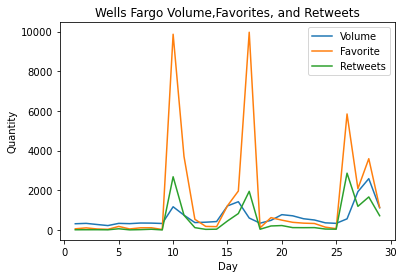

In [254]:
dates = np.linspace(1,29,29)
fav = wf_data.iloc[:,1]
retweets = wf_data.iloc[:,2]
vol = wf_data.iloc[:,7]
plot_sentiment(dates,[vol,fav,retweets], 'Wells Fargo Volume,Favorites, and Retweets','R')

### Interactions

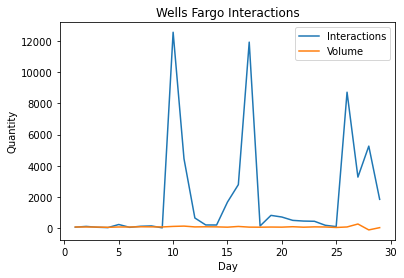

In [115]:
interactions = wf_data.iloc[:,1] + wf_data.iloc[:,2]
plot_interactions(dates, interactions, vol,'Wells Fargo Interactions')

### Sentiment Weighted

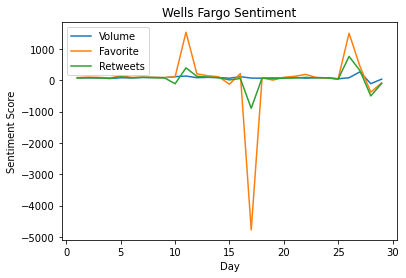

In [116]:
uw_sentiment = wf_data.iloc[:,6]
fav_sentiment = wf_data.iloc[:,11]
retweets_sentiment = wf_data.iloc[:,12]
sentiment_array = [uw_sentiment,fav_sentiment,retweets_sentiment]
plot_sentiment(dates,sentiment_array, 'Wells Fargo Sentiment','S')

### Pre Scandal

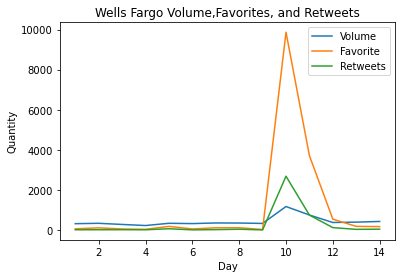

In [253]:
dates = np.linspace(1,14,14)
fav = wf_data.iloc[0:14,1]
retweets = wf_data.iloc[0:14,2]
vol = wf_data.iloc[0:14,7]
plot_sentiment(dates,[vol,fav,retweets], 'Wells Fargo Volume,Favorites, and Retweets','R')

In [64]:
sum_stats([vol,fav,retweets])

,total sentiment,Favorites,Retweets
count,14.000000,14.000000,14.000000
mean,89.259750,1084.857143,270.071429
std,18.729049,2703.843329,720.307142
min,59.619900,24.000000,3.000000
25%,80.509850,53.750000,10.500000
50%,84.564550,111.000000,24.000000
75%,92.410325,179.750000,55.750000
max,137.148300,9866.000000,2682.000000


### Post Scandal

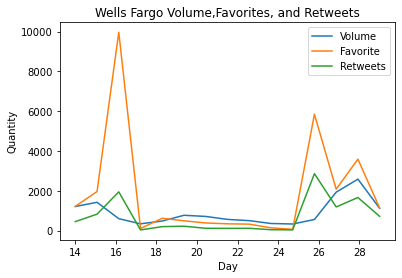

In [256]:
dates = np.linspace(14,29,15)
fav = wf_data.iloc[14:29,1]
retweets = wf_data.iloc[14:29,2]
vol = wf_data.iloc[14:29,7]
plot_sentiment(dates,[vol,fav,retweets], 'Wells Fargo Volume,Favorites, and Retweets','R')

In [69]:
sum_stats([vol,fav,retweets])

,total sentiment,Favorites,Retweets
count,15.000000,15.000000,15.000000
mean,76.148267,1886.800000,704.600000
std,73.754112,2739.329146,856.900378
min,-106.573300,66.000000,37.000000
25%,67.515200,335.500000,117.500000
50%,72.413100,622.000000,223.000000
75%,84.930800,2023.500000,1009.500000
max,271.690000,9967.000000,2863.000000


### Identifying Regimes 

In [259]:
dates = np.linspace(1,28,28)
fav = wf_data.iloc[:,1]
retweets = wf_data.iloc[:,2]
vol = wf_data.iloc[:,7]
n = 28

The number of normal periods are: 22
The number of growth periods are: 6
Growth Regime:                 0
count    6.000000
mean    86.165671
std    162.104703
min      4.074847
25%      4.375135
50%      5.490116
75%     67.261634
max    410.083333
Normal Regime:                0
count  22.000000
mean   13.545455
std     8.622933
min     0.000000
25%     6.250000
50%    13.000000
75%    20.750000
max    27.000000
The number of normal periods are: 22
The number of growth periods are: 6
Growth Regime:                 0
count    6.000000
mean   164.638471
std    357.832654
min      1.833333
25%      4.789039
50%      8.063889
75%     56.895192
max    893.000000
Normal Regime:               0
count  22.00000
mean   14.00000
std     8.41201
min     0.00000
25%     7.50000
50%    14.50000
75%    20.75000
max    27.00000
The number of normal periods are: 25
The number of growth periods are: 3
Growth Regime:               0
count  3.000000
mean   2.292577
std    0.385440
min    1.854118
25%  

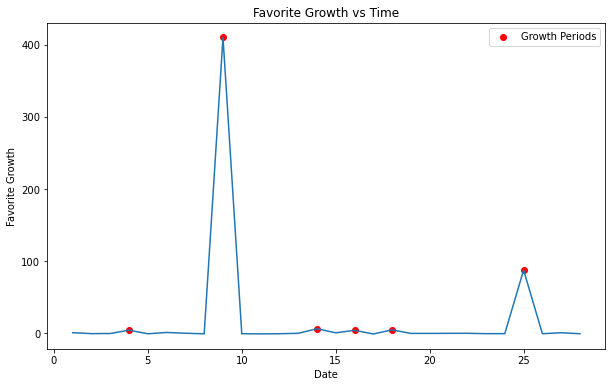

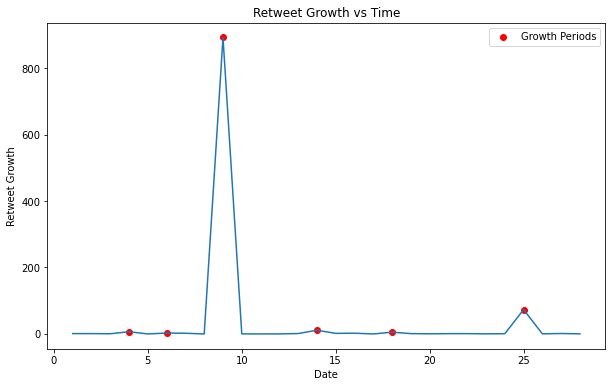

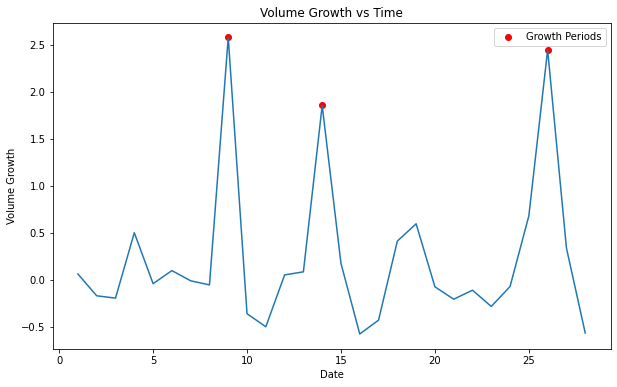

In [260]:
# Favorites 
regime_id = regime(fav, n)
plot_regime(regime_id, dates, fav, 'Favorite Growth')

# Rewteets
regime_id = regime(retweets, n)
plot_regime(regime_id, dates, retweets, 'Retweet Growth')

# Volume
regime_id = regime(vol, n)
plot_regime(regime_id, dates, vol, 'Volume Growth')

### Regime Raw

The number of normal periods are: 20
The number of growth periods are: 9
Growth Regime:                  0
count     9.000000
mean   4375.888889
std    3467.039315
min    1133.000000
25%    1964.000000
50%    3593.000000
75%    5847.000000
max    9967.000000
Normal Regime:                0
count  20.000000
mean   11.800000
std     8.134397
min     0.000000
25%     4.750000
50%    11.500000
75%    19.250000
max    24.000000
The number of normal periods are: 23
The number of growth periods are: 6
Growth Regime:                  0
count     6.000000
mean   1862.833333
std     804.984327
min     828.000000
25%    1309.500000
50%    1806.500000
75%    2498.500000
max    2863.000000
Normal Regime:                0
count  23.000000
mean   12.521739
std     8.300436
min     0.000000
25%     5.500000
50%    12.000000
75%    19.500000
max    28.000000
The number of normal periods are: 23
The number of growth periods are: 6
Growth Regime:                  0
count     6.000000
mean   1574.666667
s

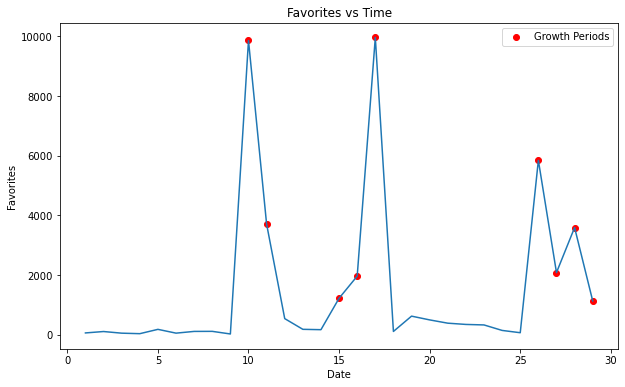

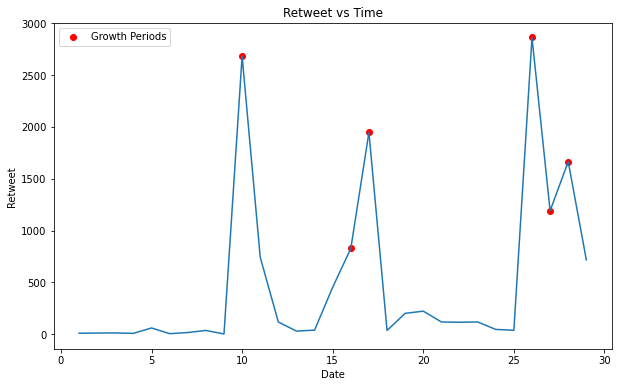

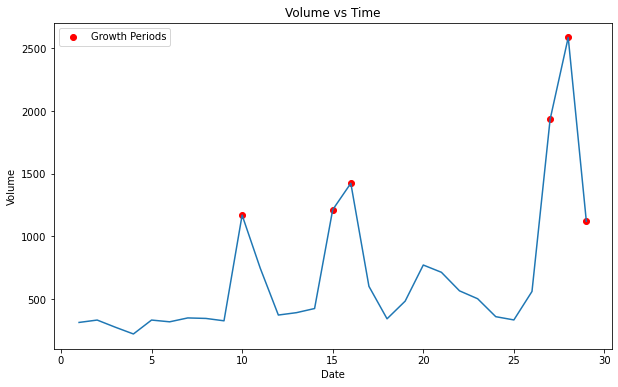

In [272]:
dates = np.linspace(1,29,29)
fav = wf_data.iloc[:,1]
retweets = wf_data.iloc[:,2]
vol = wf_data.iloc[:,7]
n = 29
regime_id = regime_raw(fav,n)
plot_regime_raw(regime_id, dates, fav, 'Favorites')
regime_id = regime_raw(retweets,n)
plot_regime_raw(regime_id, dates, retweets, 'Retweet')
regime_id = regime_raw(vol,n)
plot_regime_raw(regime_id, dates, vol, 'Volume')

## Equifax

In [245]:
ef_data = pd.read_csv("equifaxfreq.csv")
ef_data.head()

,date,Favorites,Retweets,date.1,Unnamed: 4,Unnamed: 5,total sentiment,Volume,avg sentiment,Unnamed: 9,Favorites and Retweets,weighted sentiment,avg weighted sentiment,fav sentiment,retweet sentiment
0,8/24/17,3,4,8/24/17,1:23:00,AM,2.8410,11,0.258273,NaN,7,3.9229,0.356627,3.9229,4.2841
1,8/25/17,7,0,8/24/17,9:07:00,AM,1.5400,5,0.308000,NaN,7,5.7433,1.148660,5.7433,1.5400
2,8/26/17,0,0,8/24/17,1:44:00,PM,-1.2844,5,-0.256880,NaN,0,-1.2844,-0.256880,-1.2844,-1.2844
3,8/27/17,3,0,8/24/17,1:46:00,PM,-0.7638,3,-0.254600,NaN,3,-2.6071,-0.869033,-2.6071,-0.7638
4,8/28/17,0,0,8/24/17,2:01:00,PM,0.2023,2,0.101150,NaN,0,0.2023,0.101150,0.2023,0.2023


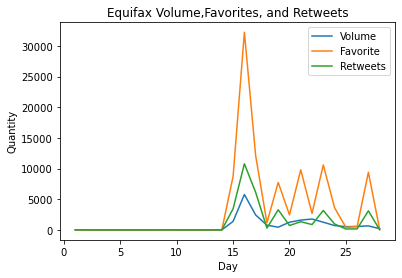

In [129]:
dates = np.linspace(1,28,28)
fav = ef_data.iloc[:,1]
retweets = ef_data.iloc[:,2]
vol = ef_data.iloc[:,7]
plot_sentiment(dates,[vol,fav,retweets], 'Equifax Volume,Favorites, and Retweets','R')

### Interactions 

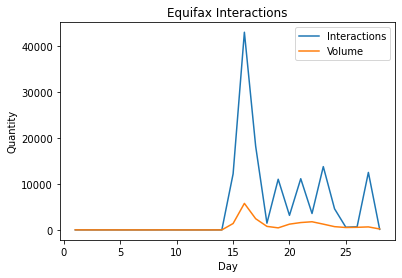

In [77]:
interactions = ef_data.iloc[:,1] + ef_data.iloc[:,2]
plot_interactions(dates, interactions, vol,'Equifax Interactions')

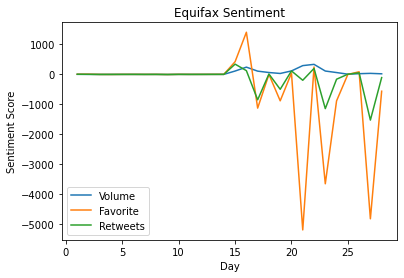

In [78]:
uw_sentiment = ef_data.iloc[:,6]
fav_sentiment = ef_data.iloc[:,13]
retweets_sentiment = ef_data.iloc[:,14]
sentiment_array = [uw_sentiment,fav_sentiment,retweets_sentiment]
plot_sentiment(dates,sentiment_array, 'Equifax Sentiment','S')

### Pre Scandal

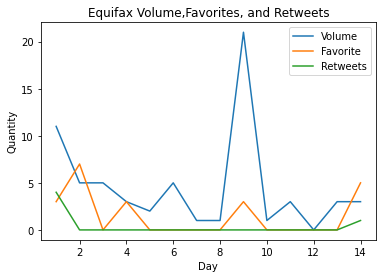

In [85]:
dates = np.linspace(1,14,14)
fav = ef_data.iloc[0:14,1]
retweets = ef_data.iloc[0:14,2]
vol = ef_data.iloc[0:14,7]
plot_sentiment(dates,[vol,fav,retweets], 'Equifax Volume,Favorites, and Retweets','R')

In [86]:
sum_stats([vol,fav,retweets])

,Volume,Favorites,Retweets
count,14.000000,14.000000,14.000000
mean,4.571429,1.500000,0.357143
std,5.459139,2.312175,1.081818
min,0.000000,0.000000,0.000000
25%,1.250000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,5.000000,3.000000,0.000000
max,21.000000,7.000000,4.000000


### Post Scandal

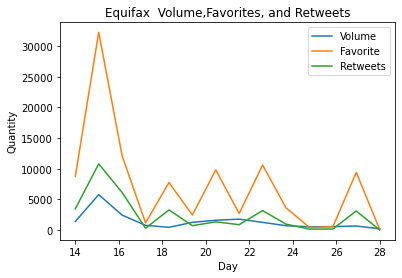

In [87]:
dates = np.linspace(14,28,14)
fav = ef_data.iloc[14:28,1]
retweets = ef_data.iloc[14:28,2]
vol = ef_data.iloc[14:28,7]
plot_sentiment(dates,[vol,fav,retweets], 'Equifax  Volume,Favorites, and Retweets','R')

In [88]:
sum_stats([vol,fav,retweets])

,Volume,Favorites,Retweets
count,14.000000,14.000000,14.000000
mean,1384.285714,7261.071429,2462.071429
std,1405.031969,8364.987208,2982.141834
min,204.000000,102.000000,23.000000
25%,589.500000,1491.500000,402.000000
50%,1012.000000,5683.000000,1154.000000
75%,1551.000000,9705.500000,3256.500000
max,5775.000000,32241.000000,10787.000000


### Identifying Regimes 

In [188]:
dates = np.linspace(1,27,27)
fav = ef_data.iloc[:,1]
retweets = ef_data.iloc[:,2]
vol = ef_data.iloc[:,7]
fav= [x+1 for x in fav]
retweets= [x+1 for x in retweets]
vol = [x+1 for x in vol]
n = 27

The number of normal periods are: 18
The number of growth periods are: 9
The number of normal periods are: 22
The number of growth periods are: 5
The number of normal periods are: 22
The number of growth periods are: 5


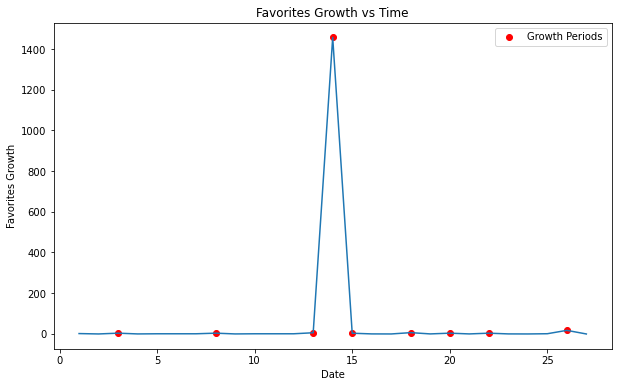

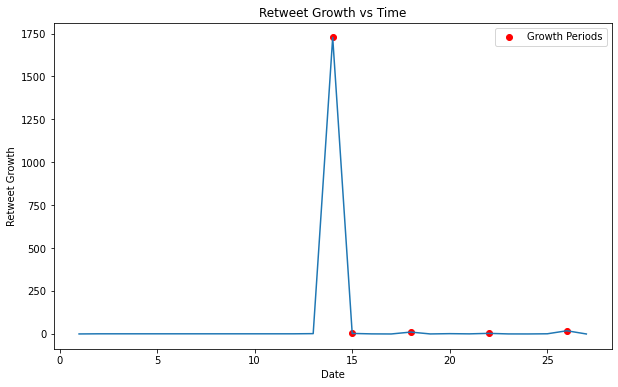

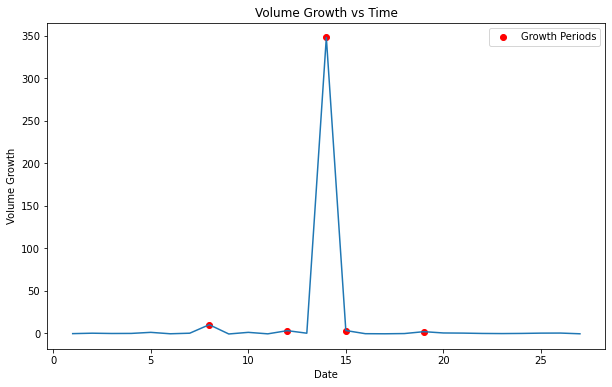

In [189]:
# Favorites 
regime_id = regime(fav,n)
plot_regime(regime_id, dates, fav, 'Favorites Growth')

# Rewteets
regime_id = regime(retweets,n)
plot_regime(regime_id, dates, retweets, 'Retweet Growth')

# Volume
regime_id = regime(vol,n)
plot_regime(regime_id, dates, vol, 'Volume Growth')

### Regime Raw

The number of normal periods are: 15
The number of growth periods are: 13
Growth Regime:                   0
count     13.000000
mean    7812.769231
std     8438.277640
min      432.000000
25%     2454.000000
50%     7744.000000
75%     9808.000000
max    32242.000000
Normal Regime:                0
count  15.000000
mean    7.866667
std     6.653320
min     0.000000
25%     3.500000
50%     7.000000
75%    10.500000
max    27.000000
The number of normal periods are: 15
The number of growth periods are: 13
Growth Regime:                   0
count     13.000000
mean    2650.692308
std     3016.683040
min      152.000000
25%      718.000000
50%     1341.000000
75%     3286.000000
max    10788.000000
Normal Regime:                0
count  15.000000
mean    7.866667
std     6.653320
min     0.000000
25%     3.500000
50%     7.000000
75%    10.500000
max    27.000000
The number of normal periods are: 14
The number of growth periods are: 14
Growth Regime:                  0
count    14.000000

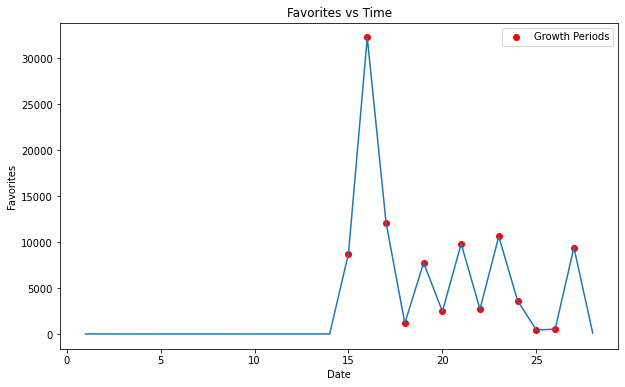

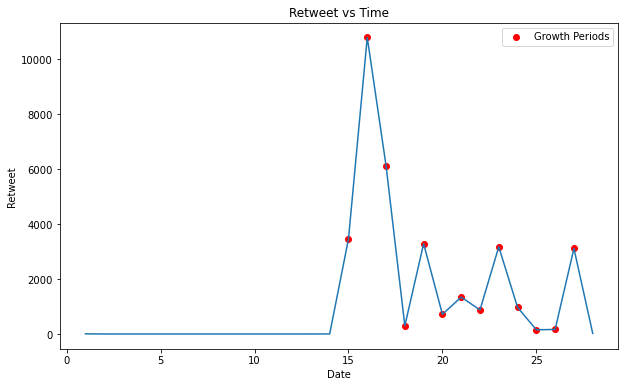

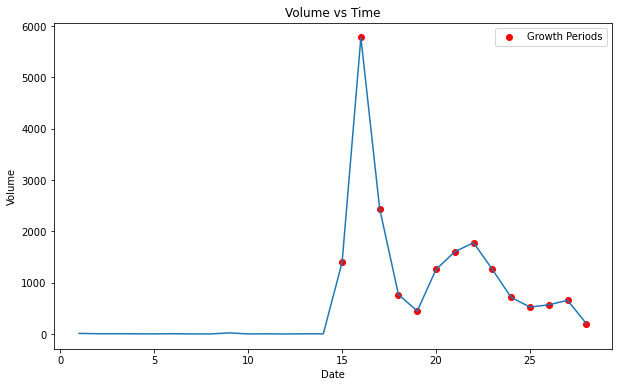

In [247]:
dates = np.linspace(1,28,28)
fav = ef_data.iloc[:,1]
retweets = ef_data.iloc[:,2]
vol = ef_data.iloc[:,7]
fav= [x+1 for x in fav]
retweets= [x+1 for x in retweets]
vol = [x+1 for x in vol]
n = 28
# Favorites 
regime_id = regime_raw(fav,n)
plot_regime_raw(regime_id, dates, fav, 'Favorites')

# Rewteets
regime_id = regime_raw(retweets,n)
plot_regime_raw(regime_id, dates, retweets, 'Retweet')

# Volume
regime_id = regime_raw(vol,n)
plot_regime_raw(regime_id, dates, vol, 'Volume')